## **My Model**

In [1]:
from pycox.datasets import support
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_ipcw , integrated_brier_score , brier_score
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torchtuples as tt
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.datasets import metabric
from pycox.models import LogisticHazard

# vars
q_cuts = 10
_cuts = 20

In [2]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [3]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x))
        return output   

In [4]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.durations.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

In [5]:
class Surv_Matrix:
    def __init__(self , duration_index , events , cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [6]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        # self.events = events
        
    def discrete_q_transform(self , q_cuts=10):
        '''
        cut at quantiles
        '''
        self.quantiles = np.linspace(0 , 1 , q_cuts)
        self.bin_edges = np.quantile(self.durations , self.quantiles) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = len(np.unique(self.duration_index))
        # print(self.n_duration_index)
        assert self.n_duration_index == q_cuts , 'must match'
        return self.duration_index
    
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [7]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

In [8]:
df = metabric.read_df()
df_train , df_test , df_val = train_test_splitter(df)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_dur , y_train_event = get_target(df_train)
y_test_dur , y_test_event = get_target(df_test)
y_val_dur , y_val_event = get_target(df_val)

In [9]:
t = Transforms(durations = y_train_dur)
dur_idx = t.discrete_transform(_cuts = q_cuts)

t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

t_val = Transforms(durations = y_val_dur)
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

In [10]:
_comp = x_train.shape[1]

pca = PCA(n_components = _comp)
fit_pca = pca.fit(x_train)
x_train = fit_pca.transform(x_train)
# reduced_features = fit_pca.transform(x_train)

pca_test = PCA(n_components = _comp)
fit_pca_test = pca_test.fit(x_test)
x_test = fit_pca_test.transform(x_test)
# reduced_features_test = fit_pca_test.transform(x_test)

pca_val = PCA(n_components = _comp)
fit_pca_val = pca_test.fit(x_val)
x_val = fit_pca_val.transform(x_val)
# reduced_features_val = fit_pca_val.transform(x_val)

In [11]:
input_size = x_train.shape[1]
hidden_size = 32
output_size = t.n_duration_index


# Create an instance of your custom dataset
dataset = MyDataset(x_train, dur_idx , y_train_event) # need to change outcomes[0] to indexed version

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 500
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 10

# build net
net = MLP(input_size , hidden_size , output_size)

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [12]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

l = generic_Loss()

best_loss = np.Inf

# Training loop
for epoch in range(num_epochs):
    for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
        # Prime for training
        net.train()
        
        # forward pass
        phi_train = net(patient_image)

        # make survival matrix
        sm = Surv_Matrix(duration_index = dur, events = eve , cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()        

        # get loss
        loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(x_val)
            val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

# turn training off
# net.eval()

Epoch 1: Training Loss: 3.3131, Val Loss: 3.2233
Epoch 51: Training Loss: 1.4052, Val Loss: 1.6147
Epoch 101: Training Loss: 1.3142, Val Loss: 1.6612
Epoch 151: Training Loss: 1.2966, Val Loss: 1.7293
Epoch 201: Training Loss: 1.2983, Val Loss: 1.7705
Epoch 251: Training Loss: 1.1855, Val Loss: 1.8404
Epoch 301: Training Loss: 1.2929, Val Loss: 1.8511
Epoch 351: Training Loss: 1.1904, Val Loss: 1.8814
Epoch 401: Training Loss: 1.0830, Val Loss: 1.9265
Epoch 451: Training Loss: 0.9745, Val Loss: 1.9979


In [13]:
with torch.no_grad():
    hazards = torch.sigmoid(net(x_test))
    survival = torch.log(1 - hazards).cumsum(1).exp()

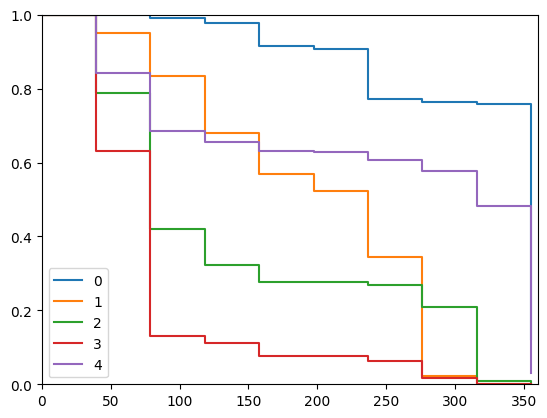

In [14]:
for i , surv in enumerate(survival.detach().numpy()[100:105]):
    plt.step(t.bin_edges , surv , where = 'post' , label = i)
    plt.legend()
    plt.ylim(0 , 1.)
    plt.xlim(0 , 360)

In [15]:
from eval_surv_copy import EvalSurv

ev_ = EvalSurv(pd.DataFrame(survival.detach().numpy().T) , y_test_dur , y_test_event , censor_surv='km')
ev_.concordance_td()

shapes : (305, 305, 305, 305)


0.5730908410282006

0.48504674706953066


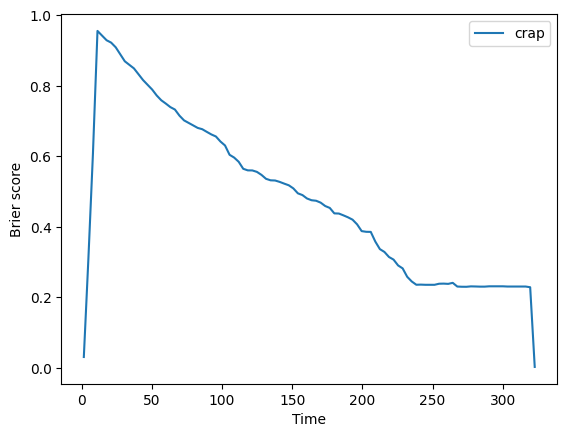

In [16]:
time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), 100)
print(ev_.integrated_brier_score(time_grid))

ev_.brier_score(time_grid).rename('crap').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

## **Comparison**

In [17]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

0:	[0s / 0s],		train_loss: 3.0593,	val_loss: 3.0273


1:	[0s / 0s],		train_loss: 2.7514,	val_loss: 2.7249
2:	[0s / 0s],		train_loss: 2.4764,	val_loss: 2.3451
3:	[0s / 0s],		train_loss: 2.1349,	val_loss: 1.9417
4:	[0s / 0s],		train_loss: 1.8160,	val_loss: 1.6423
5:	[0s / 0s],		train_loss: 1.5380,	val_loss: 1.4931
6:	[0s / 0s],		train_loss: 1.4492,	val_loss: 1.4840
7:	[0s / 0s],		train_loss: 1.4186,	val_loss: 1.4812
8:	[0s / 0s],		train_loss: 1.3762,	val_loss: 1.4702
9:	[0s / 0s],		train_loss: 1.3517,	val_loss: 1.4743
10:	[0s / 0s],		train_loss: 1.3338,	val_loss: 1.4832
11:	[0s / 0s],		train_loss: 1.3284,	val_loss: 1.4619
12:	[0s / 0s],		train_loss: 1.3074,	val_loss: 1.4448
13:	[0s / 0s],		train_loss: 1.3079,	val_loss: 1.4392
14:	[0s / 0s],		train_loss: 1.2963,	val_loss: 1.4451
15:	[0s / 0s],		train_loss: 1.3113,	val_loss: 1.4514
16:	[0s / 0s],		train_loss: 1.2994,	val_loss: 1.4609
17:	[0s / 0s],		train_loss: 1.2779,	val_loss: 1.4678
18:	[0s / 0s],		train_loss: 1.2813,	val_loss: 1.4643
19:	[0s / 0s],		train_loss: 1.2783,	val_loss: 1.4597
2

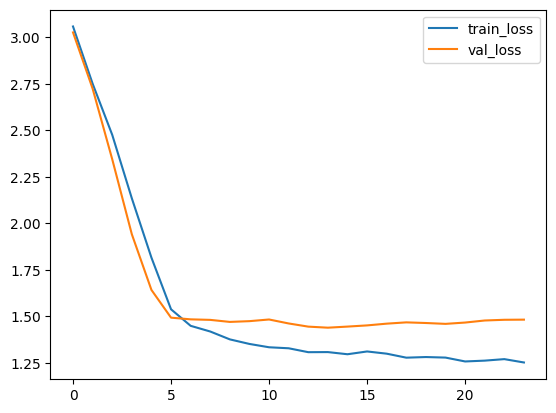

In [18]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

surv = model.predict_surv_df(x_test)

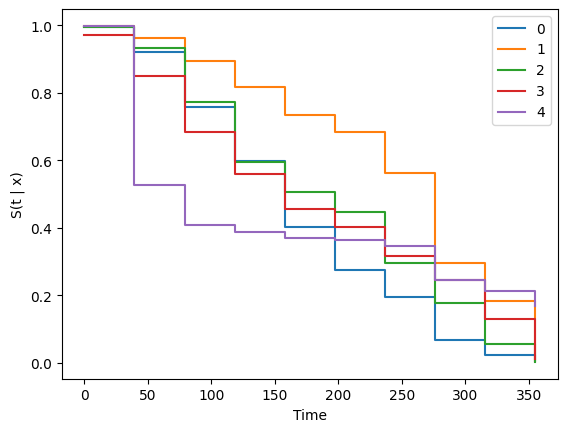

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (305, 305, 305, 305)
td-concordance 0.5652987985645187
integrated brier score 0.1873409340981679


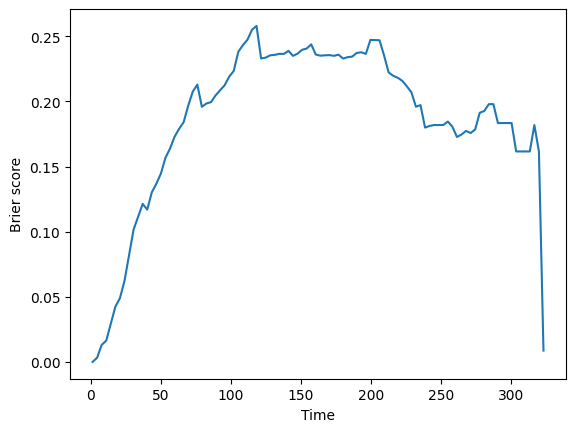

In [20]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

In [21]:
A = torch.rand(x_train.shape)
net_ = torch.nn.Sequential(
    torch.nn.Linear(input_size, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, output_size)
)

phi_1 = net_(A)

mlp = MLP(input_size , hidden_size , output_size)

phi_2 = mlp(A)


sm_val_ = Surv_Matrix(duration_index = dur_idx , events = y_train_event , cuts = q_cuts)
surv_mat_ = sm_val_.make_survival_matrix()
surv_mat_

L = generic_Loss()

loss_ = L.nll_logistic_hazard(logits = phi_1 , targets = surv_mat_ , dur_idx = dur_idx)


# print(phi_1.shape , surv_mat_.shape , loss_ ,)

In [22]:
loss_

tensor(3.4155, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [23]:
from pycox.models.loss import nll_logistic_hazard

nll_logistic_hazard(phi_1 , torch.Tensor(dur_idx).to(torch.int64), torch.Tensor(y_train_event).to(torch.float32))

tensor(3.4155, grad_fn=<MeanBackward0>)